In [1]:
import tensorflow as tf
import numpy as np
import jax
import jax.numpy as jnp
import jax.experimental.optimizers as optimizers
from jax.experimental import stax
from jax.experimental.stax import (Conv, Dense, MaxPool, Relu, Flatten)
from jax import jit, grad, random,vmap,value_and_grad
import jax.nn as jnn
from jax.tree_util import tree_multimap
import math
from scipy.special import softmax
import matplotlib.pyplot as plt
import warnings
from functools import partial # for use with vmap


In [5]:
def data_parse(record):
    features = {
        'N': tf.io.FixedLenFeature([], tf.int64),
        'labels': tf.io.FixedLenFeature([16], tf.float32),
        'elements': tf.io.VarLenFeature(tf.int64),
        'coords': tf.io.VarLenFeature(tf.float32),
    }
    parsed_features = tf.io.parse_single_example(
        serialized=record, features=features)
    coords = tf.reshape(tf.sparse.to_dense(parsed_features['coords'], default_value=0),[-1,4])
    elements = tf.sparse.to_dense(parsed_features['elements'], default_value=0)
    return (elements, coords), parsed_features['labels']
data = tf.data.TFRecordDataset(
    'qm9.tfrecords', compression_type='GZIP').map(data_parse)

In [6]:
#{'C':6,'H':1,'O':8,'N':7,'F':9}

def make_graph(e,x):
    e = e.numpy()
    x = x.numpy()
    r = x[:,:3]
    r2 = np.sum((r - r[:,np.newaxis,:])**2,axis=-1)
    edges = np.where(r2!=0, 1/r2,0.0) #[N,N]
    nodes = np.zeros((len(e),9))
    nodes[np.arange(len(e)), e-1] = 1
    return nodes,edges

def get_label(y):
    return y.numpy()[13]

In [42]:
data.take(10)

<TakeDataset shapes: (((None,), (None, 4)), (16,)), types: ((tf.int64, tf.float32), tf.float32)>

((<tf.Tensor: shape=(5,), dtype=int64, numpy=array([6, 1, 1, 1, 1])>, <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[-1.2698136e-02,  1.0858041e+00,  8.0009960e-03, -5.3568900e-01],
       [ 2.1504159e-03, -6.0313176e-03,  1.9761203e-03,  1.3392100e-01],
       [ 1.0117308e+00,  1.4637512e+00,  2.7657481e-04,  1.3392200e-01],
       [-5.4081506e-01,  1.4475266e+00, -8.7664372e-01,  1.3392299e-01],
       [-5.2381361e-01,  1.4379326e+00,  9.0639728e-01,  1.3392299e-01]],
      dtype=float32)>), <tf.Tensor: shape=(16,), dtype=float32, numpy=
array([ 1.0000000e+00,  1.5771181e+02,  1.5770998e+02,  1.5770699e+02,
        0.0000000e+00,  1.3210000e+01, -3.8769999e-01,  1.1710000e-01,
        5.0480002e-01,  3.5364101e+01,  4.4748999e-02, -4.0478931e+01,
       -4.0476063e+01, -4.0475117e+01, -4.0498596e+01,  6.4689999e+00],
      dtype=float32)>)
(5, 9) (5, 5) -40.475117
((<tf.Tensor: shape=(4,), dtype=int64, numpy=array([7, 1, 1, 1])>, <tf.Tensor: shape=(4, 4), dtype=float32, nump

/scratch/gwellawa/.conda/htf2/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


In [28]:
print(data_labels)
#print(data_nodes.shape)

[ -40.475117  -56.522083  -76.400925  -77.30458   -93.408424 -114.479805
  -79.75972  -115.67487  -116.60461  -132.71362 ]


In [5]:
def gcn_layer(nodes,edges,train_weights):
    
    #wq has shape (9,10), output from query has shape (5,10)
    query = jnp.dot(nodes,train_weights[0]) 
    

    #pairwise distances are used here wk has shape of (9,10), output from keys has shape (5,5,10)
    keys = jnp.dot(jnp.repeat(nodes[jnp.newaxis,...],nodes.shape[0],axis=0), train_weights[1]) * edges
    d_sq = math.sqrt(keys.shape[-1])
    b = jnn.softmax(query[jnp.newaxis,...] * keys/d_sq)
    
    #wv has shape (9,10), output from values has shape (5,5,10)
    values = jnp.dot(jnp.repeat(nodes[jnp.newaxis,...],nodes.shape[0],axis=0), train_weights[2])
    
    messages = b * values #out shape (5,5,10)
    
    net_message = jnp.mean(messages,axis= 1)
    self_message = nodes @ train_weights[3]
    
    #self loop
    out_nodes = jnn.relu((net_message+self_message)) 
    
    return out_nodes,edges
    
    
def graph_level_fts(nodes):
    node_avg = jnp.mean(nodes,axis=1)
    return node_avg

In [121]:
out_dim = 10
embed_dim = 4

#get node embeddings instead of one-hot 
element_embeddings = np.random.normal(size=(9,embed_dim))
embed_nodes = nodes @ element_embeddings

#get edge embeddings from pairwise distances
edge_embeddings = np.random.normal(size=(1,len(edges),out_dim))
embed_edges = edges[...,np.newaxis] * edge_embeddings

#trainable weights
w1 = np.random.normal(size = (4,embed_dim,out_dim))
w2 = np.random.normal(size = (4,embed_dim,out_dim))


#call gcn

n,e = gcn_layer(embed_nodes,embed_edges,w1)
n,e = gcn_layer(embed_nodes,embed_edges,w2)
n = graph_level_fts(n)
print(n,n.shape)



[0.23964253 1.9595194  1.9574305  1.9660587  1.9568462 ] (5,)
1604.9153 [0.18368527] -40.475117


In [ ]:
net_init, net_apply = stax.serial(
    gcn_layer
    Dense(16), Relu,
    Dense(1)
)

rng = random.PRNGKey(0)
in_shape = (-1,n.shape[0])

out_shape, net_params =net_init(rng,in_shape)
#print(net_params)

losses = loss(net_params,n,label)
#losses = vmap(partial(loss, net_params))(n, label)
#print(predictions)
print(losses,pred,label)

opt_init, opt_update,get_params = optimizers.adam(step_size=1e-2)
opt_state = opt_init(net_params)

params = get_params(opt_state)

up_params, opt_state, loss = update(params, n, label, opt_state)


In [119]:
r = np.repeat(nodes[np.newaxis,...],nodes.shape[0],axis=0) @ np.ones((9,10 )) 
r.shape

a = jnp.ones((5,5))
b = jnp.ones((5,10))
c = a@b

print(c.shape)
#print(softmax(c).shape)

(5, 10)


In [ ]:
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
losses = vmap(partial(loss, net_params))(xrange_inputs, targets) # per-input loss
plt.plot(xrange_inputs, predictions, label='prediction')
plt.plot(xrange_inputs, losses, label='loss')
plt.plot(xrange_inputs, targets, label='target')
plt.legend()

In [32]:
out_dim = 10
input_shape = (5,10)
output_shape = input_shape[:-1] + (out_dim,)
print(input_shape[:-1])
print(output_shape )

(5,)
(5, 10)


In [10]:

for d in data:
    (e,x),y = d
    nodes,edges = make_graph(e,x)
    label = get_label(y)
    print (nodes.shape,edges.shape,label)
    break


(5, 9) (5, 5) -40.475117


/scratch/gwellawa/.conda/htf2/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


In [62]:
i = 0
data_nodes,data_edges,data_labels = [],[],[]
 
for d in data:
    print (d)
    (e,x),y = d
    nodes,edges = make_graph(e,x)
    label = get_label(y)
    
    data_nodes.append(nodes)
    data_edges.append(edges)
    data_labels.append(label)
    print (nodes.shape,edges.shape,label)
    i +=1
    if i ==1000:
        break
        
data_nodes = np.asarray(data_nodes)
data_edges = np.asarray(data_edges)
data_labels = np.asarray(data_labels)
print(data_nodes.shape) 
print(data_edges.shape) 
print(data_labels.shape) 



((<tf.Tensor: shape=(5,), dtype=int64, numpy=array([6, 1, 1, 1, 1])>, <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[-1.2698136e-02,  1.0858041e+00,  8.0009960e-03, -5.3568900e-01],
       [ 2.1504159e-03, -6.0313176e-03,  1.9761203e-03,  1.3392100e-01],
       [ 1.0117308e+00,  1.4637512e+00,  2.7657481e-04,  1.3392200e-01],
       [-5.4081506e-01,  1.4475266e+00, -8.7664372e-01,  1.3392299e-01],
       [-5.2381361e-01,  1.4379326e+00,  9.0639728e-01,  1.3392299e-01]],
      dtype=float32)>), <tf.Tensor: shape=(16,), dtype=float32, numpy=
array([ 1.0000000e+00,  1.5771181e+02,  1.5770998e+02,  1.5770699e+02,
        0.0000000e+00,  1.3210000e+01, -3.8769999e-01,  1.1710000e-01,
        5.0480002e-01,  3.5364101e+01,  4.4748999e-02, -4.0478931e+01,
       -4.0476063e+01, -4.0475117e+01, -4.0498596e+01,  6.4689999e+00],
      dtype=float32)>)
(5, 9) (5, 5) -40.475117
((<tf.Tensor: shape=(4,), dtype=int64, numpy=array([7, 1, 1, 1])>, <tf.Tensor: shape=(4, 4), dtype=float32, nump

/scratch/gwellawa/.conda/htf2/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


((<tf.Tensor: shape=(7,), dtype=int64, numpy=array([8, 6, 6, 7, 7, 1, 1])>, <tf.Tensor: shape=(7, 4), dtype=float32, numpy=
array([[-1.40710957e-02,  1.31731355e+00,  9.31443181e-03,
        -1.58910006e-01],
       [ 1.25702548e+00,  1.70028603e+00, -8.20794783e-04,
         4.51399982e-02],
       [ 2.05020714e+00,  5.99664271e-01, -1.43590672e-02,
        -1.08627997e-01],
       [ 1.20496917e+00, -4.87319380e-01, -1.21534150e-02,
        -1.05360001e-01],
       [ 4.98780981e-03, -1.21775314e-01,  1.41811103e-03,
         6.66100020e-03],
       [ 1.45532405e+00,  2.75964284e+00,  2.98618618e-03,
         1.72793999e-01],
       [ 3.12108421e+00,  4.96438891e-01, -2.51924414e-02,
         1.48302004e-01]], dtype=float32)>), <tf.Tensor: shape=(16,), dtype=float32, numpy=
array([ 1.7100000e+02,  1.0426020e+01,  9.8440504e+00,  5.0633402e+00,
        3.4410999e+00,  3.2490002e+01, -2.8619999e-01, -4.4000000e-02,
        2.4220000e-01,  2.5657739e+02,  4.5382001e-02, -2.6203513e+02,
  

(11, 9) (11, 11) -248.12521
((<tf.Tensor: shape=(10,), dtype=int64, numpy=array([6, 6, 6, 7, 6, 7, 1, 1, 1, 1])>, <tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[-0.01799589,  1.5531723 ,  0.00864997, -0.387375  ],
       [-0.01782321,  0.00450261,  0.0370554 , -0.272702  ],
       [ 0.71910703, -0.5078408 ,  1.201797  ,  0.298007  ],
       [ 1.3255175 , -0.88184035,  2.1099644 , -0.296538  ],
       [-1.3874847 , -0.529899  ,  0.01202382,  0.298007  ],
       [-2.4722579 , -0.92160875, -0.03496524, -0.296539  ],
       [ 1.0109031 ,  1.9174819 , -0.00923096,  0.154438  ],
       [-0.5395765 ,  1.9012479 , -0.8849223 ,  0.154438  ],
       [-0.52083844,  1.9511226 ,  0.89159465,  0.164864  ],
       [ 0.49300787, -0.36741778, -0.8605183 ,  0.183401  ]],
      dtype=float32)>), <tf.Tensor: shape=(16,), dtype=float32, numpy=
array([ 3.2900000e+02,  5.6139498e+00,  2.8376501e+00,  2.0072300e+00,
        4.1272001e+00,  4.7230000e+01, -3.4330001e-01, -1.2900000e-02,
        3.303

(14, 9) (14, 14) -270.39105
((<tf.Tensor: shape=(12,), dtype=int64, numpy=array([8, 6, 6, 6, 8, 6, 1, 1, 1, 1, 1, 1])>, <tf.Tensor: shape=(12, 4), dtype=float32, numpy=
array([[-0.05203717,  1.4420934 ,  0.0437988 , -0.449751  ],
       [-0.01458751,  0.06408519,  0.0277771 ,  0.313541  ],
       [-0.28783643, -0.78340495, -1.1968215 , -0.355044  ],
       [-1.136503  , -0.93939143,  0.03994915,  0.054016  ],
       [-0.47684374, -1.7721663 ,  0.99620146, -0.283347  ],
       [ 0.60090667, -0.80251443,  1.1265944 , -0.133325  ],
       [ 0.6168467 ,  1.7721246 , -0.5660416 ,  0.290673  ],
       [-0.769296  , -0.23475967, -2.0014074 ,  0.117493  ],
       [ 0.3816436 , -1.5834221 , -1.50292   ,  0.114587  ],
       [-2.2158868 , -0.8593701 ,  0.07979627,  0.113939  ],
       [ 1.5885235 , -1.2462707 ,  0.95381   ,  0.101703  ],
       [ 0.568023  , -0.31707165,  2.108414  ,  0.115514  ]],
      dtype=float32)>), <tf.Tensor: shape=(16,), dtype=float32, numpy=
array([ 4.8300000e+02,  6.5

(17, 9) (17, 17) -251.72359
((<tf.Tensor: shape=(16,), dtype=int64, numpy=array([6, 6, 8, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])>, <tf.Tensor: shape=(16, 4), dtype=float32, numpy=
array([[-4.6701850e-03,  1.4680657e+00, -1.1495558e-01, -3.9613801e-01],
       [ 1.3888010e-04, -4.4278797e-02,  1.1864745e-01,  1.2624900e-01],
       [ 6.9793642e-01, -3.7694633e-01,  1.3186030e+00, -4.3218300e-01],
       [-1.3966067e+00, -6.2994164e-01,  9.6076168e-02,  2.0829000e-02],
       [-2.0010064e+00, -1.1109251e+00, -1.2004420e+00, -2.6651701e-01],
       [-1.5917153e+00, -2.1027231e+00, -1.4034680e-01, -2.6739401e-01],
       [ 1.0151166e+00,  1.8612119e+00, -8.8645637e-02,  1.2123500e-01],
       [-4.5506841e-01,  1.7163744e+00, -1.0811757e+00,  1.1802100e-01],
       [-5.8671063e-01,  1.9767019e+00,  6.6405797e-01,  1.0297300e-01],
       [ 5.8791745e-01, -5.2587372e-01, -6.7346126e-01,  8.0496997e-02],
       [ 2.0631850e-01,  2.2283923e-03,  2.0554032e+00,  2.7287000e-01],
       [-2.08475

(13, 9) (13, 13) -377.7645
((<tf.Tensor: shape=(18,), dtype=int64, numpy=array([6, 6, 6, 6, 6, 7, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])>, <tf.Tensor: shape=(18, 4), dtype=float32, numpy=
array([[ 0.03293207,  1.5603993 , -0.06513987, -0.380392  ],
       [-0.04478306,  0.03331362,  0.02352543, -0.042977  ],
       [ 0.6784659 , -0.48348835,  1.2848105 , -0.386201  ],
       [-1.4598638 , -0.50808084, -0.02772723,  0.361002  ],
       [-1.672413  , -1.9896708 , -0.20541528, -0.469837  ],
       [-2.4183931 ,  0.3286534 ,  0.08793371, -0.169106  ],
       [-3.6731327 , -0.30757302,  0.04932808, -0.405964  ],
       [ 1.0793083 ,  1.8821461 , -0.07368623,  0.100142  ],
       [-0.45311505,  1.9322262 , -0.97042406,  0.119028  ],
       [-0.46449882,  2.028311  ,  0.78862864,  0.126555  ],
       [ 0.47770187, -0.3913227 , -0.8472079 ,  0.081832  ],
       [ 0.21087413, -0.07541789,  2.1871805 ,  0.123787  ],
       [ 0.6532372 , -1.5749217 ,  1.3560473 ,  0.115174  ],
       [ 1.7279861 , 

(13, 9) (13, 13) -340.66382
((<tf.Tensor: shape=(15,), dtype=int64, numpy=array([6, 6, 6, 7, 7, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1])>, <tf.Tensor: shape=(15, 4), dtype=float32, numpy=
array([[ 0.08364881,  1.5186869 ,  0.01707675, -0.50763   ],
       [ 0.04731657,  0.02062725,  0.01895985,  0.260081  ],
       [-0.04127706, -0.79309374, -1.0954901 ,  0.149871  ],
       [-0.12122338, -0.54350835, -2.4882321 , -0.616028  ],
       [-0.04633961, -2.0996432 , -0.6627791 , -0.23867   ],
       [ 0.0369345 , -2.141351  ,  0.70249003, -0.088273  ],
       [ 0.09636618, -0.8432755 ,  1.1538624 , -0.240083  ],
       [ 1.0035796 ,  1.908202  ,  0.46951312,  0.12233   ],
       [ 0.03041702,  1.9096284 , -1.0042727 ,  0.099963  ],
       [-0.75405174,  1.9509901 ,  0.57749635,  0.122328  ],
       [-0.9408068 ,  0.00446149, -2.7283874 ,  0.241715  ],
       [ 0.6886329 , -0.03602261, -2.829204  ,  0.24171   ],
       [-0.10416627, -2.883119  , -1.2899175 ,  0.256842  ],
       [ 0.04699429, -3.07886

In [63]:
out_dim = 10
embed_dim = 4
num_steps = 10
train_loss = []
mean_l2=[]
def loss(params, inputs, targets):
    # Computes average loss for the batch
    predictions = net_apply(params, inputs)
    #todo: add reg
    l2=np.mean((targets - predictions)**2)
    #print('loss',l2)
    return l2

@jit
def update(i, opt_state,inputs,targets):
    params = get_params(opt_state)
    return opt_update(i, grad(loss)(params,inputs,targets), opt_state)

def GCN(out_dim,embed_dim):
    def init_fun(rng,input_shape):
        output_shape = input_shape[:-1] + (out_dim,)
        #trainable weights
        w = np.random.normal(size = (4,embed_dim,out_dim))
        w1 = w[0]
        w2 = w[1]
        w3 = w[2]
        w4 = w[3]
        #w2 = np.random.normal(size = (4,embed_dim,out_dim))
        return output_shape, (w1,w2,w3,w4)
    
    def apply_fun(train_weights,inputs, **kwargs):
        #wq has shape (9,10), output from query has shape (5,10)
        nodes,edges = inputs

        #print('nodes and weights',nodes.shape,train_weights[0].shape)
        query = jnp.dot(nodes,train_weights[0]) 

        #pairwise distances are used here wk has shape of (9,10), output from keys has shape (5,5,10)
        keys = jnp.dot(jnp.repeat(nodes[jnp.newaxis,...],nodes.shape[0],axis=0), train_weights[1]) * edges
        d_sq = math.sqrt(keys.shape[-1])
        b = jnn.softmax(query[jnp.newaxis,...] * keys/d_sq)

        #wv has shape (9,10), output from values has shape (5,5,10)
        values = jnp.dot(jnp.repeat(nodes[jnp.newaxis,...],nodes.shape[0],axis=0), train_weights[2])

        messages = b * values #out shape (5,5,10)

        net_message = jnp.mean(messages,axis= 1)
        self_message = nodes @ train_weights[3]

        #self loop
        #out_nodes = jnp.mean(jnn.relu((net_message+self_message)) )
        #todo: get mean
        out_nodes = jnp.mean(jnn.relu((net_message+self_message)))
        #print(out_nodes.shape)
        #node_avg = jnp.mean(nodes,axis=1)

        return out_nodes
    
    return init_fun,apply_fun
  

#gcn_init,gcn_apply = GCN(out_dim,embed_dim)
#out_dims, out_w = gcn_init(out_dim,embed_nodes.shape)
#n,e = gcn_apply(out_w,inputs)
#print(n.shape)

#net_init, net_apply = stax.serial(GCN(out_dim,embed_dim),GCN(out_dim,embed_dim))

#todo: remove dense
net_init, net_apply = stax.serial(
    GCN(out_dim,embed_dim),
    Dense(16), Relu,
    Dense(1)
)

rng = random.PRNGKey(0)
#in_shape = (-1,n.shape[0])
train_loss = []
for i in range(len(data_nodes)):
    #get node embeddings instead of one-hot 
    element_embeddings = np.random.normal(size=(9,embed_dim))
    embed_nodes = data_nodes[i] @ element_embeddings
    #print(embed_nodes.shape)

    #get edge embeddings from pairwise distances
    edge_embeddings = np.random.normal(size=(1,len(data_edges[i]),out_dim))
    embed_edges = data_edges[i][...,np.newaxis] * edge_embeddings

    out_shape, net_params =net_init(rng,embed_nodes.shape)
    #print(embed_nodes.shape,out_shape)

    inputs = (embed_nodes,embed_edges)
    label = data_labels[i]
    #losses = loss(net_params,inputs,label)

    opt_init, opt_update,get_params = optimizers.adam(step_size=1e-2)
    opt_state = opt_init(net_params)

    
    for i in range(num_steps):
        opt_state = update(i, opt_state,inputs,label)
    trained_params = get_params(opt_state)
    train_loss.append(loss(trained_params,inputs,label))

    
print(train_loss)

[DeviceArray(1533.2527, dtype=float32), DeviceArray(3058.0369, dtype=float32), DeviceArray(5701.879, dtype=float32), DeviceArray(5858.9585, dtype=float32), DeviceArray(8581.22, dtype=float32), DeviceArray(12905.442, dtype=float32), DeviceArray(6242.1465, dtype=float32), DeviceArray(13210.17, dtype=float32), DeviceArray(13452.729, dtype=float32), DeviceArray(17306.504, dtype=float32), DeviceArray(23345.574, dtype=float32), DeviceArray(28561.713, dtype=float32), DeviceArray(14003.2, dtype=float32), DeviceArray(23748.926, dtype=float32), DeviceArray(23773.576, dtype=float32), DeviceArray(13702.041, dtype=float32), DeviceArray(23415.393, dtype=float32), DeviceArray(36985.895, dtype=float32), DeviceArray(43204.523, dtype=float32), DeviceArray(50419.05, dtype=float32), DeviceArray(24720.707, dtype=float32), DeviceArray(37297.188, dtype=float32), DeviceArray(23319.592, dtype=float32), DeviceArray(28485.025, dtype=float32), DeviceArray(34157.375, dtype=float32), DeviceArray(36056.676, dtype=fl

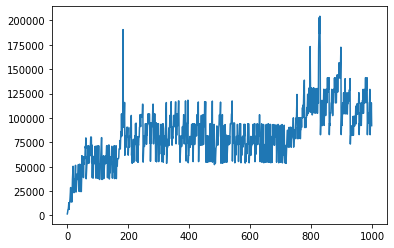

In [64]:
plt.plot(train_loss, label='Training Loss')

plt.show()

In [60]:
losses = loss(net_params,n,label)

opt_init, opt_update,get_params = optimizers.adam(step_size=1e-2)
opt_state = opt_init(net_params)

params = get_params(opt_state)

up_params, opt_state, loss = update(params, n, label, opt_state)
